In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import os
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import gc
import datetime
import re

In [4]:
print(os.listdir("./data/raw/"))
train_transaction = pd.read_csv('./data/raw/train_transaction.csv', index_col='TransactionID',nrows=50000)
#test_transaction = pd.read_csv('./input/test_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('./data/raw/train_identity.csv', index_col='TransactionID')
#test_identity = pd.read_csv('./input/test_identity.csv', index_col='TransactionID')
print('dimensions:\n')
print('train_transaction: ' + str(train_transaction.shape))
#print('test_transaction: ' + str(test_transaction.shape))
print('train_identity: ' + str(train_identity.shape))
#print('test_identity: ' + str(test_identity.shape))

['.gitkeep', 'sample_submission.csv', 'test_identity.csv', 'test_identity_small.csv', 'test_transaction.csv', 'test_transaction_small.csv', 'train_identity.csv', 'train_identity_med.csv', 'train_identity_small.csv', 'train_transaction.csv', 'train_transaction_med.csv', 'train_transaction_small.csv']
dimensions:

train_transaction: (50000, 393)
train_identity: (144233, 40)


In [ ]:
#df_less_10000 = train_transaction.loc[train_transaction['TransactionAmt']<10000]
#sns.scatterplot(y=df_less_10000['TransactionAmt'],x=df['TransactionDT'],hue=df['isFraud'], linewidth=0,alpha=0.1)

In [6]:
print('************transaction columns:\n')
for i in train_transaction.columns:
    print(i,end=', ')
print('\n\n************identity columns:\n')
for i in train_identity.columns:
    print(i,end=', ')

************transaction columns:



NameError: name 'train_transaction' is not defined

**Left inner join the 2 dataframes on the TransactionID column:**

In [5]:
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
#test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
del train_transaction
#del test_transaction 
del train_identity 
#del test_identity
gc.collect()

103

In [7]:
for i in train:
    print(i)

isFraud
TransactionDT
TransactionAmt
ProductCD
card1
card2
card3
card4
card5
card6
addr1
addr2
dist1
dist2
P_emaildomain
R_emaildomain
C1
C2
C3
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
M1
M2
M3
M4
M5
M6
M7
M8
M9
V1
V2
V3
V4
V5
V6
V7
V8
V9
V10
V11
V12
V13
V14
V15
V16
V17
V18
V19
V20
V21
V22
V23
V24
V25
V26
V27
V28
V29
V30
V31
V32
V33
V34
V35
V36
V37
V38
V39
V40
V41
V42
V43
V44
V45
V46
V47
V48
V49
V50
V51
V52
V53
V54
V55
V56
V57
V58
V59
V60
V61
V62
V63
V64
V65
V66
V67
V68
V69
V70
V71
V72
V73
V74
V75
V76
V77
V78
V79
V80
V81
V82
V83
V84
V85
V86
V87
V88
V89
V90
V91
V92
V93
V94
V95
V96
V97
V98
V99
V100
V101
V102
V103
V104
V105
V106
V107
V108
V109
V110
V111
V112
V113
V114
V115
V116
V117
V118
V119
V120
V121
V122
V123
V124
V125
V126
V127
V128
V129
V130
V131
V132
V133
V134
V135
V136
V137
V138
V139
V140
V141
V142
V143
V144
V145
V146
V147
V148
V149
V150
V151
V152
V153
V154
V155
V156
V157
V158
V159
V160
V161
V162
V163
V164
V165
V166
V167
V168
V169
V17

Engineer some date/time features from TransactionDT:

In [ ]:
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
train['TransactionDT'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
train['time_year'] = train['TransactionDT'].dt.year
train['time_month'] = train['TransactionDT'].dt.month
train['time_dow'] = train['TransactionDT'].dt.dayofweek
train['time_hour'] = train['TransactionDT'].dt.hour
train['time_day'] = train['TransactionDT'].dt.day


Number of days spanned by data:

In [ ]:
(train['TransactionDT'].max()-train['TransactionDT'].min())/(60*60*24)

So remove:

In [ ]:
train = train.drop(columns="TransactionDT")
train = train.drop(columns="time_year")
train = train.drop(columns="time_month")

Function for getting some details for each variable:

In [ ]:
#this takes ages so let's skip it for now
#fig, ax = plt.subplots(figsize=(20,20))
#a=sns.heatmap(train_transaction.select_dtypes(exclude=['object']).corr())

For each column check if there is any other column that is highly correlated.  If so then remove the column that has the most NAs out the pair.

In [ ]:
def remove_highly_correlated_columns(df,threshold,label):
    to_remove=[]
    corr_matrix = df[df[label].notnull()].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    for i in upper.columns:
        for j in upper[i].index:
            if upper[i][j]>threshold:
                if df[i].isna().sum()>df[j].isna().sum():
                    to_remove.append(i)
                else:
                    to_remove.append(j)
    to_remove = list(set(to_remove))
    return to_remove
#to_remove=remove_highly_correlated_columns(train,0.98,'isFraud')
#print(train.shape)
#train=train.drop(columns=to_remove)
#print(train.shape)

function to get summary of each variable:

In [ ]:
def get_summary(df):
    name = []
    nunique = []
    dtype = []
    maxv = []
    minv = []
    NANprop = []
    boolean_numeric = []
    values = []
    for i in df.columns:
        name.append(i)
        nunique.append(df[i].nunique(dropna=False))
        dtype.append(str(df[i].dtype))
        if str(df[i].dtype) != 'object':
            maxv.append(df[i].max())
        else:
            maxv.append(None)
        if str(df[i].dtype) != 'object':
            minv.append(df[i].min())
        else:
            minv.append(None)
        NANprop.append(df[i].isna().sum()/df[i].shape[0])
        values.append(df[i].value_counts(dropna=False).head(5).index.astype(str).str.cat(sep=','))
            
            
    summary = pd.DataFrame()
    summary['name'] = name
    summary['dtype'] = dtype
    summary['max'] = maxv
    summary['min'] = minv
    summary['NANprop'] = NANprop
    summary['nunique'] = nunique
    summary['Top 5 Values'] = values
    return summary


Some functions for plotting some useful charts:

In [ ]:
def compare_dens_plots_fraud_for_numerical(df,colname,hist=False,kde=True):
    fig, ax = plt.subplots(figsize=(15,3))
    a = sns.distplot(df[colname],color='blue',kde_kws={'alpha':0.5,"shade": True},hist=hist,kde=kde)
    #a.set_ylabel('total proportion',fontdict={'color':'blue'})
    ax2 = ax.twinx()
    b = sns.distplot(df.loc[df['isFraud']==1][colname],color='red',kde_kws={'alpha':0.5,"shade": True},hist=hist,kde=kde)
    b.set_ylabel('% of frauds',fontdict={'color':'red'})
#compare_dens_plots_fraud_for_numerical(trai,'V310')
#compare_dens_plots_fraud_for_numerical(train,'TransactionAmt')

def prop_of_values_and_prop_of_frauds_for_non_numerical(df,colname):
    goodbadpallette = ["#e74c3c","#2ecc71"]
    #df=train_transaction
    #colname='card4'
    prop_of_frauds=[]
    values = []
    occurences = []
    occurences_fraud = []
    occurences_not_fraud = []
    column = df[[colname,'isFraud']]
    #column[[colname]]=column[[colname]].fillna(value='NAN')
    column.fillna({colname:'NAN'}, inplace=True)
    fig, ax = plt.subplots(figsize=(20,3))
    a1=sns.countplot(data=column,x=colname,hue='isFraud',order = column[colname].value_counts().index)
    ax2 = ax.twinx()
    fraud_counts = pd.DataFrame(column.loc[column['isFraud']==1][colname].value_counts(dropna=False))
    total_counts = pd.DataFrame(column[colname].value_counts(dropna=False))
    fraudprop = fraud_counts/total_counts*100
    fraudprop['total_count']=total_counts
    fraudprop=fraudprop.sort_values(by='total_count',ascending=False)
    a2=sns.pointplot(fraudprop.index, y=fraudprop[colname],marker='o',order=fraudprop.index,ax=ax2)
    a2.set_ylabel('% of frauds in class')
    for label in a1.get_xticklabels():
        label.set_rotation(45)
#prop_of_values_and_prop_of_frauds_for_non_numerical(train,'card4')

def prop_of_values_and_prop_of_frauds_for_numerical(df,colname,bins):
    if df[colname].nunique()<bins:
        bins=df[colname].nunique()
    binned_name = colname + '_binned'
    df[binned_name] = pd.cut(train[colname],bins=bins)
    df['ones']=[1] * df.shape[0]
    fig, ax = plt.subplots(figsize=(15,3))
    props = df.groupby(binned_name).sum()['isFraud']/df.groupby(binned_name).sum()['ones']*100
    a2 = sns.countplot(df[binned_name])
    ax2 = ax.twinx()
    a1 = sns.pointplot(x=props.index,y=props)
    for label in a2.get_xticklabels():
            label.set_rotation(45)
    a1.set_ylabel('% of frauds')
    plt.show()
#prop_of_values_and_prop_of_frauds_for_numerical(train,'time_hour',20)

def boxen_plot_for_categorical_column_vs_numerical_column(df,catcolname,numcolname,numcolcutoff=None):
    if numcolcutoff is None:
        numcolcutoff = max(df[numcolname])
    fig, ax = plt.subplots(figsize=(20,3))
    a = sns.boxenplot(x=catcolname, y=numcolname, hue='isFraud',data=df[df[numcolname] <= numcolcutoff] )
    for item in a.get_xticklabels():
        item.set_rotation(45)
#boxen_plot_for_categorical_column_vs_numerical_column(train_transaction,'card4','TransactionAmt',numcolcutoff=2000)

**Some nice looking graphs:**

In [ ]:
train['time_hour_rounded'] = round(train['time_hour'])
train['time_hour_rounded'].unique()
df=train
df['ones']=[1] * df.shape[0]
df=train
fig, ax = plt.subplots(figsize=(8,3))
props = df.groupby('time_hour_rounded').sum()['isFraud']/df.groupby('time_hour_rounded').sum()['ones']*100
a2 = sns.countplot(df['time_hour_rounded'])
ax2 = ax.twinx()
a1 = sns.pointplot(x=props.index,y=props,color='red')
for label in a2.get_xticklabels():
        label.set_rotation(45)
a1.set_ylabel('fraud %',fontdict={'color':'red','weight':'bold'})
a2.set_xlabel('hour of day')

plt.show()
#################
#train['card4'] = round(train['time_hour'])
train['card4'].unique()
df['ones']=[1] * df.shape[0]
df=train
fig, ax = plt.subplots(figsize=(8,3))
props = df.groupby('card4').sum()['isFraud']/df.groupby('card4').sum()['ones']*100
a2 = sns.countplot(df['card4'],order=props.index,palette='Set2')
ax2 = ax.twinx()
a1 = sns.pointplot(x=props.index,y=props,color='red')
for label in a2.get_xticklabels():
        label.set_rotation(45)
a1.set_ylabel('fraud %',fontdict={'color':'red','weight':'bold'})
a2.set_xlabel('card type')
plt.show()
#############
df=train
df=df.loc[df['TransactionAmt']<1000]
colname='TransactionAmt'
fig, ax = plt.subplots(figsize=(8,3))
a = sns.distplot(df[colname],color='blue',kde_kws={'alpha':0.3,"shade": True},hist=False,kde=True)
#a.set_ylabel('total proportion',fontdict={'color':'blue'})
ax2 = ax.twinx()
b = sns.distplot(df.loc[df['isFraud']==1][colname],color='red',kde_kws={'alpha':0.3,"shade": True},hist=False,kde=True)
b.set_ylabel('proportion of fraud transactions',fontdict={'color':'red'})
a.set_ylabel('proportion of all transactions',fontdict={'color':'blue'})
a.set_xlabel('Transaction Amount')
plt.show()
del df 
#del test_identity
gc.collect()

In [ ]:
column_group_regex = ['TransactionDT|TransactionAmt|ProductCD','card\d','addr\d','dist\d','\w_emaildomain','C\d{1,2}','D\d{1,2}','M\d{1,2}','V\d+','time_','Device\w+','id_']
for i in column_group_regex:
    display(get_summary(train.filter(regex=i))) 

id_30 corresponds to device, we'll group some types to give fewer categories:

The dataset is very imbalanced with many more non-fraudlulant transactions:

In [ ]:
sns.distplot(train['isFraud'],kde=False,rug=True,bins=2);

In [ ]:
id_30_regex={'(?i)^.*Android.*$':'Android',
               '(?i)^.*iOS.*$':'iOS',
               '(?i)^.*Windows.*$':'Windows',
               '(?i)^.*Mac\sOS.*$':'Mac'
              }
train['id_30']=train['id_30'].replace(regex=id_30_regex)

In [ ]:
prop_of_values_and_prop_of_frauds_for_non_numerical(train,'id_30')

id_31 corresponds to browsers, we'll group some types to give fewer categories

In [ ]:
id_31_regex={'(?i)^.*samsung.*$':'samsung',
               '(?i)^.*safari.*$':'safari',
               '(?i)^.*chrome.*$':'chrome',
               '(?i)^.*firefox.*$':'firefox',
               '(?i)^.*opera.*$':'opera',
               '(?i)^.*edge.*$':'edge',
               '(?i)^.*ie\s\d{1,2}.*$':'ie',
              '(?i)^.*android.*$':'android',
              '(?i)^.*google.*$':'google',
              }

train['id_31']=train['id_31'].replace(regex=id_31_regex)


In [ ]:
prop_of_values_and_prop_of_frauds_for_non_numerical(train,'id_31')

Interesting, 100% of transactions with 'icedragon' for fraudelent.  However there were only 5 o f these in total so the statistical significance should be questioned

Sam for DeviceInfo:

In [ ]:
train['DeviceInfo'].value_counts()
device_regex={'^.*SM.*$|^.*(?i)SAMSUNG.*$':'Samsung',
             '(?i)^.*HUAWEI.*$|(?i)^hi\d.*$':'Huawei',
             '(?i)^.*TRIDENT.*$':'Trident',
             '(?i)rv\:.*$':'Firefox',
             '(?i)Moto.*$':'Moto',
              '(?i)Lg.*$':'Lg',
              '(?i)Linux.*$':'Linux',
             '(?i)HTC.*$':'HTC',
             '(?i)Hisense.*$':'Hisense',
             '(?i)Blade.*$':'Blade',
             '(?i)^.*XT\d+.*$':'Motorola',
             '(?i)^F\d{4}\sBuild.*$':'Sony',
             '(?i)^Lenovo.*$':'Lenovo',
             '(?i)^Redmi.*$':'Xiaomi',
             '(?i)^KFFOWI.*$':'Amazon',
             '(?i)^Pixel.*$|(?i)^Nexus.*$':'Google',
              '(?i)^Ilium.*$':'Lanix',
              '(?i)^Windows.*$':'Windows',
              '(?i)^\d{4}A.*$':'Alcatel'}
train['DeviceInfo']= train['DeviceInfo'].replace(regex=device_regex)

Top 20 devices with proportion of frauds.  Amazon devices have a high proportion of Fraud, around 80% out of 65 transactions

In [ ]:
prop_of_values_and_prop_of_frauds_for_non_numerical(train.loc[train['DeviceInfo'].isin(train['DeviceInfo'].value_counts()[:20].index)],'DeviceInfo')

Show the number of columns by type:

In [ ]:
types = []
for i in train:
    types.append(str(train[i].dtype))
pd.Series(types).value_counts().plot('bar')

Create lists of categorical and non-categorical features (according to Kaggle guide)

In [ ]:
categorical_group_regex_transaction = 'ProductCD|card[1-6]|addr\d|\w_emaildomain|M[1-9]|time_|Device\w+|id_12|id_13|id_14|id_15|id_16|id_17|id_18|id_19|id_20|id_21|id_22|id_23|id_24|id_25|id_26|id_27|id_28|id_29|id_30|id_31|id_32|id_33|id_34|id_35|id_36|id_37|id_38'
categorical = []
numerical = []
for i in train:
    if re.match(categorical_group_regex_transaction,i):
        categorical.append(i)
    #if column is numeirc but only has values of 0 and 1 (and maybe NA) then we'll assign as categorical
    else: numerical.append(i)

For the categorical variables we can replace NA values with string 'NAN':

In [76]:
categorical_group_regex_transaction = 'ProductCD|card[1-6]|addr\d|\w_emaildomain|M[1-9]|time_|Device\w+|id_12|id_13|id_14|id_15|id_16|id_17|id_18|id_19|id_20|id_21|id_22|id_23|id_24|id_25|id_26|id_27|id_28|id_29|id_30|id_31|id_32|id_33|id_34|id_35|id_36|id_37|id_38'
for i in train:
    if re.match(categorical_group_regex_transaction,i):
        train[i].fillna("NAN", inplace=True)

Some of the numeric fields are actually categorical:  We don't want our model to treat these as actual numerical values, as these don't actually have an ordinal relationship.

In [79]:
categorical_group_regex_transaction = 'ProductCD|card[1-6]|addr\d|\w_emaildomain|M[1-9]|time_|Device\w+|id_12|id_13|id_14|id_15|id_16|id_17|id_18|id_19|id_20|id_21|id_22|id_23|id_24|id_25|id_26|id_27|id_28|id_29|id_30|id_31|id_32|id_33|id_34|id_35|id_36|id_37|id_38'
for i in train:
    if re.match(categorical_group_regex_transaction,i) and train[i].dtype!='O':
        train[i] = train[i].astype(str)


['card1', 'time_dow', 'time_hour', 'time_day']

In [87]:
#categorical_group_regex_transaction = 'ProductCD|card[1-6]|addr\d|\w_emaildomain|M[1-9]|time_|Device\w+|id_12|id_13|id_14|id_15|id_16|id_17|id_18|id_19|id_20|id_21|id_22|id_23|id_24|id_25|id_26|id_27|id_28|id_29|id_30|id_31|id_32|id_33|id_34|id_35|id_36|id_37|id_38'
#categorical = []
#numerical = []
#for i in train:
#    if re.match(categorical_group_regex_transaction,i):
#        categorical.append(i)
#    #if column is numeirc but only has values of 0 and 1 (and maybe NA) then we'll assign as categorical
#    elif np.array_equal(np.sort(train[i].dropna().unique()),[0,1]):
#        categorical.append(i)
#    else: numerical.append(i)
#categorical.remove('isFraud')

Function to replace low frequency categorical variables with 'other'

In [88]:
def assign_low_freq_values_as_other(df,colname,n):
    #df = df[colname]
    topn = df[colname].value_counts(dropna=False).head(n)
    if topn.shape[0] < n:
        return df
    uniques = df[colname].unique()
    others = []
    for i in uniques:
        if i not in topn:
            others.append(i)
    for i in others:
        df[colname].replace(i,'other',inplace=True)
    return df
#assign_low_freq_values_as_other(train_transaction,'addr2',30)

Let's apply this to the categorical variables:

In [89]:
for i in train[categorical]:
    assign_low_freq_values_as_other(train,i,30)

KeyboardInterrupt: 

Compare estimated prob density plots for fraud and non-fraud by transaction amount, it looks like transaction amount is important for predicting fraud:

In [ ]:
compare_dens_plots_fraud_for_numerical(train,'TransactionAmt')

Showing total usage and proportion of fraud for card types, Discover seems to suffer a high proportion of fraud

In [ ]:
prop_of_values_and_prop_of_frauds_for_non_numerical(train,'card4')

We can see that although the number of transactions is low around 0500-0800, the relative proportion of fraud is high:

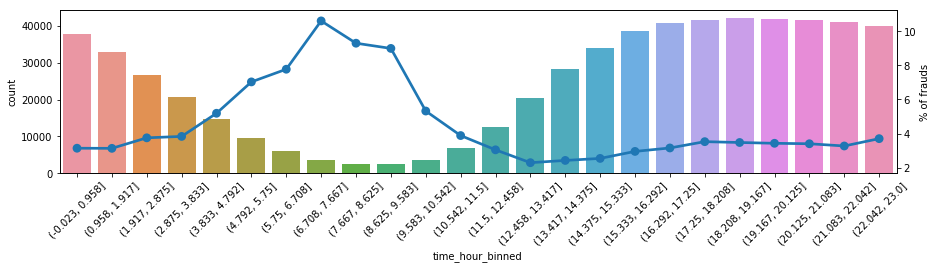

In [62]:
prop_of_values_and_prop_of_frauds_for_numerical(train,'time_hour',24)

C:\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


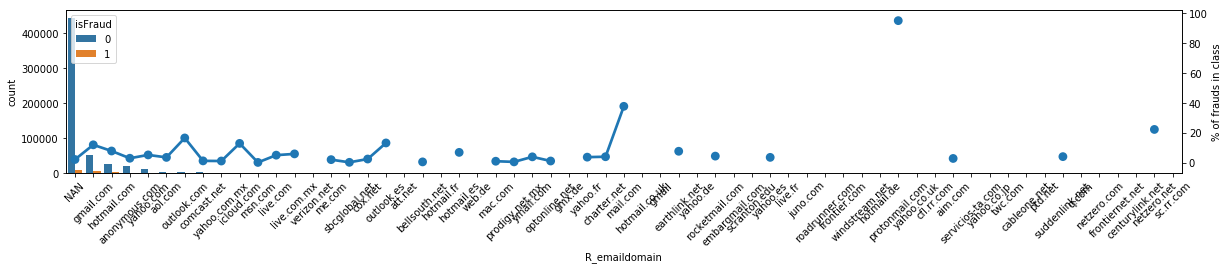

In [11]:
prop_of_values_and_prop_of_frauds_for_non_numerical(train,'R_emaildomain')

C:\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


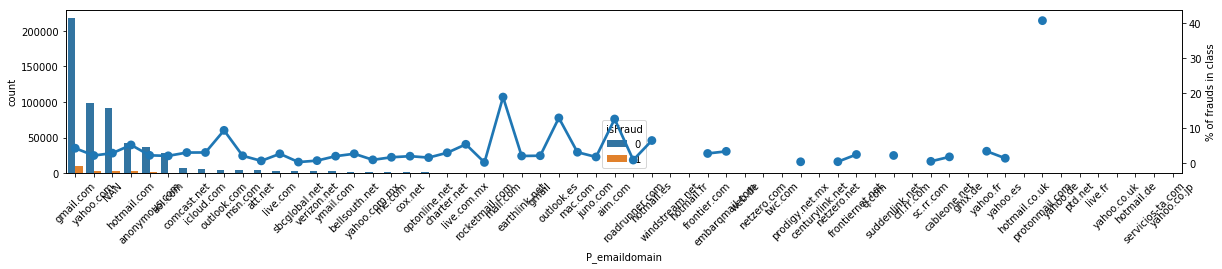

In [12]:
prop_of_values_and_prop_of_frauds_for_non_numerical(train,'P_emaildomain')

Example of comparing some the transaction amounts for types of card:

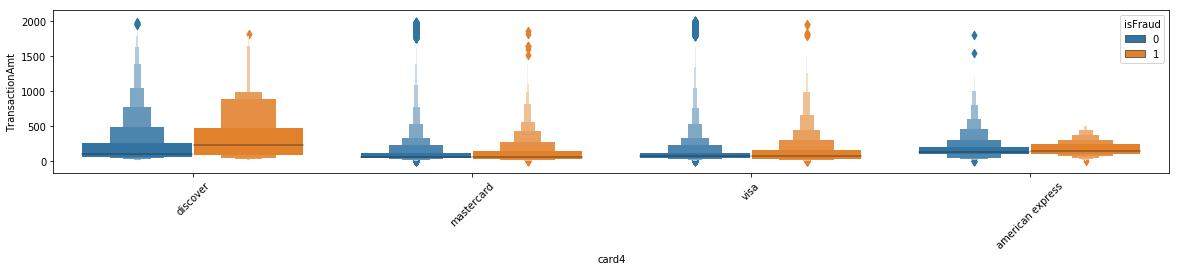

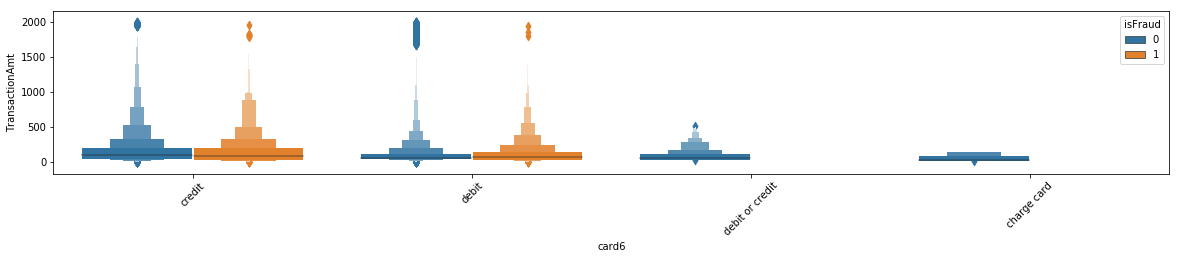

In [63]:
boxen_plot_for_categorical_column_vs_numerical_column(train,'card4','TransactionAmt',numcolcutoff=2000)
boxen_plot_for_categorical_column_vs_numerical_column(train,'card6','TransactionAmt',numcolcutoff=2000)

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


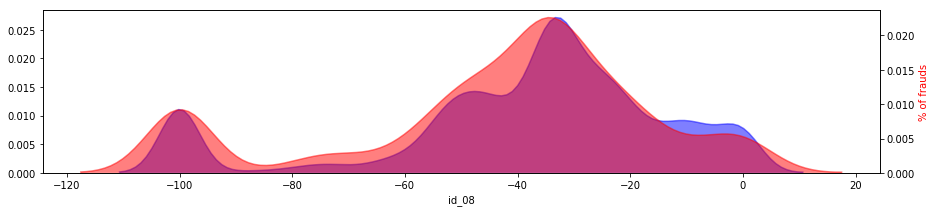

In [64]:
compare_dens_plots_fraud_for_numerical(train,'id_08')

Plot the numerical variables:

In [65]:
#for i in train[numerical].columns:
    #prop_of_values_and_prop_of_frauds_for_numerical(train,i,30)

In [66]:
#fig, ax = plt.subplots(10, 1, figsize=(10, 10))
#plt.tight_layout()
#for i in (categorical):
#    if str(train[i].dtype)=='object':
#        prop_of_values_and_prop_of_frauds_for_non_numerical(train,i)
#    else:
#        prop_of_values_and_prop_of_frauds_for_numerical(train,i,25)


In [67]:
#print(len(numerical) + len(categorical))
#print(train.columns)
set(train.columns) - set(numerical+categorical)

{'isFraud', 'time_hour_binned'}

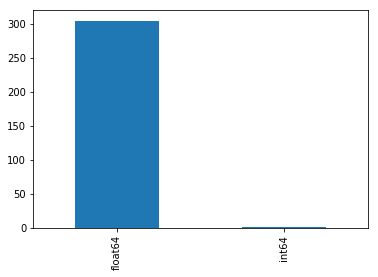

In [68]:
types = []
for i in train[numerical]:
    types.append(str(train[numerical][i].dtype))
pd.Series(types).value_counts().plot('bar')

In [70]:
train[categorical]=train[categorical].astype(str)
train_categorical_one_hot = pd.get_dummies(train[categorical])
train_categorical_one_hot.head()

MemoryError: 

In [80]:
train_categorical_one_hot.shape

(590540, 18066)

In [73]:
train[categorical].shape

(590540, 61)

In [81]:
gc.collect()
features = pd.concat([train[categorical], train_categorical_one_hot], axis=1)

MemoryError: 

In [77]:
gc.collect()
features = pd.merge(train_categorical_one_hot,train[numerical],left_index=True,right_index=True)
#train_processed = pd.merge(labels,features,left_index=True,right_index=True)
#del features
#gc.collect()
#train_processed.head()

MemoryError: 

**DRAFT WORK BELOW THIS POINT**

We can split the columns into the following groups:

The transaction and identity datasets are linked by the TransactionID, so we will do a join based on that. We will get all the transactions and add the identity columns if there is a match on TransactionID. IF not there will be null values

In [34]:
#train_identity['id_05'].isna().sum()/train_identity['id_05'].shape[0]*100
#NAs=[]
#for i in train_identity:
##    print(i)
##    train_identity[i]
#    NAs.append(train_identity[i].isna().sum()/train_identity[i].shape[0]*100)
#NAs
#NAs.sort_values(ascending=False).head(10)

Remove any variables with only one unique value, (there aren't any):

In [35]:
#remove = [c for c
#        in list(train_identity)
#        if len(train_identity[c].unique()) == 1]
#remove
#train = train[keep]
#train.shape

We can see most of the columns are integer or float ie numeircal columns.  We can assume the object columns are categorical:

We want to find the column names for numerical and categorical values. Some of the numeircal variables look like they're actually boolean values encoded as 0/1.  We don't want our model to treat these as actual numerical values, as these don't actually have an ordinal relationship.  We'll identify these and split them off too:

Let's look at the categorical variables (including the boolean numerical ones):

In [36]:
#fig, ax = plt.subplots(10, 4, figsize=(8, 20))
#plt.tight_layout()
#for variable, subplot in zip(numerical_bool+categorical, ax.flatten()):
#    sns.countplot(train[variable], ax=subplot)
#    #for label in subplot.get_xticklabels():
#        #label.set_rotation(90)

Let's look at the numerical variables:

In [37]:
#fig, ax = plt.subplots(99, 4, figsize=(8, 198))
#plt.tight_layout()
#for variable, subplot in zip(numerical, ax.flatten()):
#    train[variable].dropna()
#    sns.distplot(train[variable].dropna(),kde=False, ax=subplot)

One hot encode categorical and numerical-boolean values

In [38]:
#train_categorical_one_hot = pd.get_dummies(train[categorical])
#train_categorical_one_hot.head()

Merge the processed dataframes back together and add in the labels too

In [39]:
#train_numerical = train[numerical] 
#del train
#gc.collect()


In [40]:
#features = pd.merge(train_categorical_one_hot,train_numerical,left_index=True,right_index=True)
#train_processed = pd.merge(labels,features,left_index=True,right_index=True)
#del features
#gc.collect()
#train_processed.head()

In [41]:
#train_processed.to_csv('./train_processed.csv')
#print(os.listdir("."))

<a href="train_processed.csv"> Download File </a>

**List variables with size and then delete and clean up if not needed**

In [79]:
#del train_cat
gc.collect()

181

In [78]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' By Fred Cirera, after https://stackoverflow.com/a/1094933/1870254'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name,value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name,sizeof_fmt(size)))

     train_categorical_one_hot:  10.0GiB
                         train:   3.4GiB
                           _30:  88.3KiB
                          _i18:   3.0KiB
                          _i46:   3.0KiB
                     numerical:   2.5KiB
                         types:   2.5KiB
                          _i19:   1.8KiB
                          _i47:   1.8KiB
                  LabelEncoder:   1.0KiB


In [43]:
#del train_categorical_one_hot
import gc
gc.collect()

0